## Adaptive data retrieval demo

In [35]:
from app.dataprocessing.data_handler import DataHandler
from app.dataprocessing.benchmark import Timer, Plot, get_file_size_MB
from dotenv import load_dotenv
import os
import numpy as np

### Example 1: Copernicus dataset with 3 dimensions accessed via OPeNDAP

The OPeNDAP protocol provides subsetting of data on-demand, and initially only provides meta-data about the data.
This meta-data is enough to generate the different data structures

European Ocean- Sea Surface Temperature L4 analysis

source: https://resources.marine.copernicus.eu/product-detail/SST_EUR_PHY_L4_NRT_010_031/DATA-ACCESS

In [36]:
"""
Copernicus uses CAS SSO for authentication.
user credentials are saved in .env file.
"""

load_dotenv()
USERNAME = os.environ.get('CMEMS_CAS_USERNAME')
PASSWORD = os.environ.get('CMEMS_CAS_PASSWORD')

cas_url = 'https://cmems-cas.cls.fr/cas/login'

dataset_url = 'https://nrt.cmems-du.eu/thredds/dodsC/METEOFRANCE-EUR-SST-L4-NRT-OBS_FULL_TIME_SERIE'

##### Create DataHandler instance, this class will later be directly mapped to the API endpoints

Datastructure is automatically selected based on number of dimensions in the dataset

In [37]:
# Create a DataHandler object, one instance per dataset is required
data_handler = DataHandler()

# Establish connection to the remote data source

# Note: The OPeNDAP access class will estimate the total file size by downloanding a small slice of the dataset. 
# This will take some time, and therefore file size of the dataset should be provided as parameter if known
data_handler.set_opendap_cas(cas_url, dataset_url, USERNAME, PASSWORD)

# Set the maximum chunk size in MB. 
# keep in mind that the client can possibly work with multiple chunks simoultaneously to increase interactivity. This is a design choice front-end.
data_handler.set_max_chunk_size(50)

# Show the auto-selected data structure
print(f'Data structure in use: {data_handler.data_structure}')

Data structure in use: Octree with 4096 chunks of maximum size 50MB


##### Display meta data

In [38]:
print(f'data set total size: {data_handler.data_source.file_size_MB} MB')
print(data_handler.ds)

data set total size: 27817 MB
<xarray.Dataset>
Dimensions:           (lat: 2500, lon: 4750, time: 409)
Coordinates:
  * lat               (lat) float32 20.01 20.03 20.05 ... 69.95 69.97 69.99
  * lon               (lon) float32 -39.99 -39.97 -39.95 ... 54.95 54.97 54.99
  * time              (time) datetime64[ns] 2020-11-18 2020-11-19 ... 2022-01-01
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
Attributes: (12/50)
    title:                      Euro SST, L4, 0.02deg daily, MeteoFrance
    myocean_id:                 SST_EUR_SST_L4_NRT_OBSERVATIONS_010_009_c
    summary:                    A merged, multi-sensor L4 subskin SST product...
    processing_level:           L4
    product_id:                 SST_EUR_L4_NRT_OBSERVATIONS_010_018
    Conventions:                CF-1.4
    ...                         ...
  

##### Request the inital dataset and render

Finished 'Get inital dataset from server' in 37.7521 seconds
File size: 38.67 MB


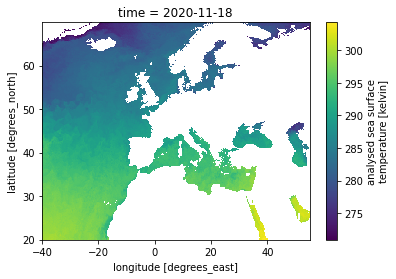

In [39]:
with Timer('Get inital dataset from server'):
    file_name = data_handler.get_inital_netcdf()
print(f'File size: {get_file_size_MB(file_name):.2f} MB')

Plot.netcdf_color_contour(data_variable='analysed_sst', netcdf_file=file_name)


##### The initial dataset equals the "root" chunk in the data structure. After requesting it from the server it is cached locally. The next request for this particular chunk will take advantage of the cache.

Finished 'Get inital dataset from local cache' in 0.4189 seconds
File size: 38.67 MB


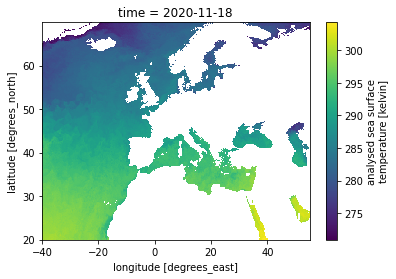

In [40]:
with Timer('Get inital dataset from local cache'):
    file_name = data_handler.get_inital_netcdf()
print(f'File size: {get_file_size_MB(file_name):.2f} MB')

Plot.netcdf_color_contour(data_variable='analysed_sst', netcdf_file=file_name)

##### Next step is to query area of interest e.g. area between The British Isles and Greenland 2020-11-18

Observe that the server will fetch the best fitting chunk to the bounds and time range requested. In the case below it will return a larger time range than necessary. This is due to the nature of how the dataset is split. There may exist a more sophisticated way of splitting the data into chunks

Finished 'Fetch the chunk covering the area between The British Isles and Greenland' in 15.2425 seconds
File size: 27.90 MB
Dimensions of current chunk Frozen({'lat': 250, 'lon': 475, 'time': 41})


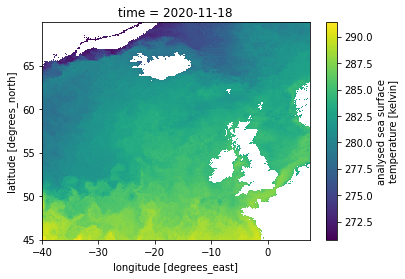

In [41]:
query_bounds = ((45,69), (-39,7), (np.datetime64('2020-11-18'), np.datetime64('2020-11-19')))

with Timer('Fetch the chunk covering the area between The British Isles and Greenland'):
    file_name, xr_chunk = data_handler.request_data_netcdf(query_bounds, return_xr_chunk=True)
print(f'File size: {get_file_size_MB(file_name):.2f} MB')
print(f'Dimensions of current chunk {xr_chunk.ds.dims}')

Plot.netcdf_color_contour(data_variable='analysed_sst', netcdf_file=file_name)

##### The client will zoom into an area of interest. This could for example be the sea area between ireland and britain

Finished 'Fetch the chunk covering the sea area between ireland and britain' in 11.6350 seconds
File size: 16.14 MB
Dimensions of current chunk Frozen({'lat': 209, 'lon': 396, 'time': 34})


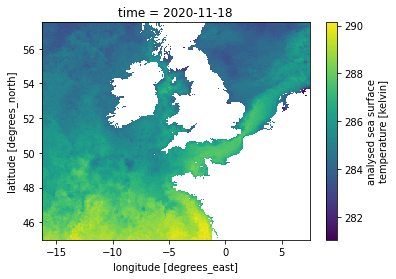

In [42]:
query_bounds = ((53.236217,55.009163), (-6.471515,-3.173936), (np.datetime64('2020-11-18'), np.datetime64('2020-11-19')))

with Timer('Fetch the chunk covering the sea area between ireland and britain'):
    file_name, xr_chunk = data_handler.request_data_netcdf(query_bounds, return_xr_chunk=True)
print(f'File size: {get_file_size_MB(file_name):.2f} MB')
print(f'Dimensions of current chunk {xr_chunk.ds.dims}')

Plot.netcdf_color_contour(data_variable='analysed_sst', netcdf_file=file_name)

##### The above plot shows the complete lat,lon range of the returned chunk. It is possible to slice the dataset to fit the requested at the cost of extra processing:

Finished 'Fetch the chunk covering the sea area between ireland and britain' in 0.0750 seconds
File size: 0.04 MB


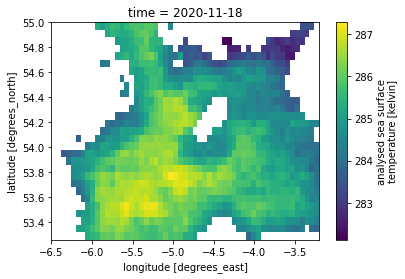

In [43]:
query_bounds = ((53.236217,55.009163), (-6.471515,-3.173936), (np.datetime64('2020-11-18'), np.datetime64('2020-11-19')))

with Timer('Fetch the chunk covering the sea area between ireland and britain'):
    file_name, xr_chunk = data_handler.request_data_netcdf(query_bounds, return_xr_chunk=True, fit_bounds=True)
print(f'File size: {get_file_size_MB(file_name):.2f} MB')

Plot.netcdf_color_contour(data_variable='analysed_sst', netcdf_file=file_name)

##### Here is the data at full resolution at requested bounds, directly fetched from Copernicus

Observation: We can se that this is at a higher resolution than what the Octree can provide. This is due to the fact that the chunks include the time axis which uses a lot of the point_budget AND that the area in interest overlaps two chunks in the higher res layer below.

Possible solutions:
- Assume that the client can handle e.g. 4 chunks instead of 1
- split the data in a way that favors large x,y range and small z range or vice versa
- Set the max_chunk_size after the dataset meta-data is known, either manual or by some algorithms

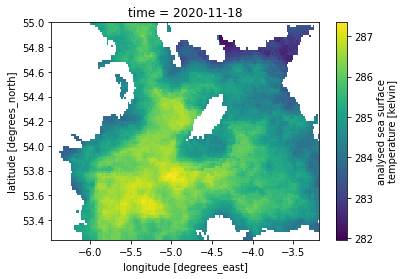

In [44]:
import xarray as xr
sub = data_handler.ds.sel(lat=slice(53.236217,55.009163),
                lon=slice(-6.471515,-3.173936),
                time=slice(np.datetime64('2020-11-18'), np.datetime64('2020-11-19')))
sub.to_netcdf('orig_d.nc')

Plot.netcdf_color_contour(data_variable='analysed_sst', netcdf_file='orig_d.nc')


### Example 2: QuadTree on 7,5GB local dataset

In [45]:
from app.dataprocessing.local.local_netcdf_reader import LocalNetcdfReader
from app.datastructures.two_dimensional.quad_tree import QuadTree

r = LocalNetcdfReader(2)
tree = QuadTree(max_chunk_size=50, original_file_size=7470,
                dataset=r.get_dataset())

##### Requst inital dataset and render